# Scaler dataframe for Auger Open Data 
### A Neutron Monitor Comparison

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import augerscalerpy.plot_config as pc
from augerscalerpy.scaler_cleaning import scaler_clean, plot_data ## ESTA SÍ ESSSSS LA FORMAAAAAAAAAAA!!!!!!!!


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
NM = pd.read_csv('nm_data/NM_izmiran.csv')
NM

,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01 00:00:00,324.971,54.535,217.712,148.928,101.445
1,2006-01-02 00:00:00,325.676,54.639,219.248,149.769,102.270
2,2006-01-03 00:00:00,325.625,54.759,219.858,150.274,102.841
3,2006-01-04 00:00:00,325.846,54.859,219.925,150.447,103.335
4,2006-01-05 00:00:00,325.585,54.897,219.698,150.377,102.962
...,...,...,...,...,...,...
5656,2021-06-27 00:00:00,null,56.098,229.513,127.708,111.792
5657,2021-06-28 00:00:00,null,55.974,228.834,127.550,111.660
5658,2021-06-29 00:00:00,null,56.076,228.892,127.555,111.742
5659,2021-06-30 00:00:00,null,56.167,229.522,128.031,111.810


## Bases de datos disponibles

#### https://www.nmdb.eu/nest/
#### https://cidas.isee.nagoya-u.ac.jp/WDCCR/station_list.php
#### Las páginas oficiales de las estaciones: http://cr0.izmiran.ru/common/
#### El servicio de IZMIRAN http://cr0.izmiran.ru/rome/main.htm

Fuentes de datos oficiales con los datos corregidos:
#### México: http://www.cosmicrays.unam.mx/
#### Oulu: https://cosmicrays.oulu.fi/
#### Rome: Revisar este --> http://webusers.fis.uniroma3.it/svirco/pag_2.html


In [3]:
#### ES UN DATO POR DÍA

cutNM = NM[NM['DATE'] >= "2006-01-01"]
cutfNM = cutNM[cutNM['DATE'] <= "2021-12-30" ]

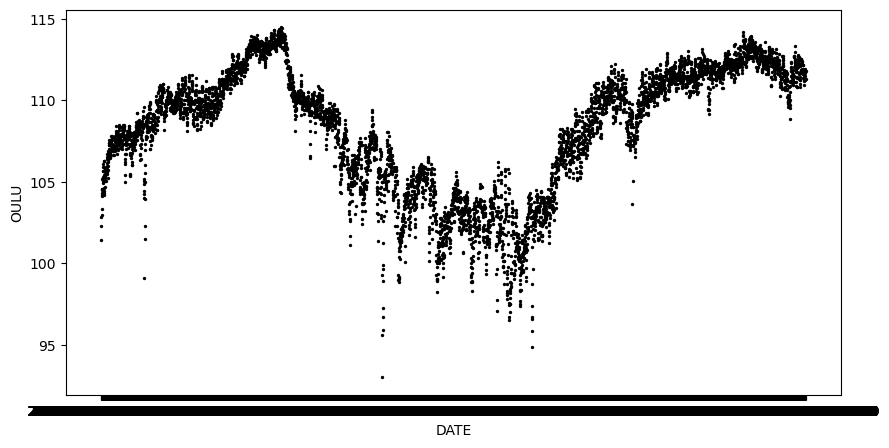

In [4]:
cutfNM.plot(kind='scatter', s= 2, x='DATE',y='OULU', figsize=(10, 5),color='black')
plt.show()

In [99]:
#replacing NaN values

#rigcut['TSMB'] = rigcut['TSMB'].fillna(0)
#cutfNM = cutfNM.fillna(0)
#cutfNM = cutfNM.replace(to_replace = '   null', value = 0.00)
#cutfNM.interpolate(inplace=True)
cutfNM.replace('   null', np.nan, inplace=True)

In [100]:
cutfNM.interpolate(inplace=True)

/tmp/ipykernel_11007/455035404.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  cutfNM.interpolate(inplace=True)


In [101]:
# ADDING SCALER DATASET
scaler3600s = scaler_clean('scaler_ALL_hourly_11abril.csv','scaler_hourly')

Hay  (11805, 4) líneas vacías


In [102]:
newrg = pd.to_datetime(cutfNM['DATE'])
cutfNM["DATE"] = newrg.values
cutfNM

,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01,324.971,54.535,217.712,148.928,101.445
1,2006-01-02,325.676,54.639,219.248,149.769,102.270
2,2006-01-03,325.625,54.759,219.858,150.274,102.841
3,2006-01-04,325.846,54.859,219.925,150.447,103.335
4,2006-01-05,325.585,54.897,219.698,150.377,102.962
...,...,...,...,...,...,...
5656,2021-06-27,NaN,56.098,229.513,127.708,111.792
5657,2021-06-28,NaN,55.974,228.834,127.550,111.660
5658,2021-06-29,NaN,56.076,228.892,127.555,111.742
5659,2021-06-30,NaN,56.167,229.522,128.031,111.810


In [103]:
cutfNM["TSMB"] = cutfNM["TSMB"].astype(float)
cutfNM["ATHN"] = cutfNM["ATHN"].astype(float)
cutfNM["MXCO"] = cutfNM["MXCO"].astype(float)
cutfNM["ROME"] = cutfNM["ROME"].astype(float)
cutfNM["OULU"] = cutfNM["OULU"].astype(float)

In [104]:
cutfNM

,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01,324.971,54.535,217.712,148.928,101.445
1,2006-01-02,325.676,54.639,219.248,149.769,102.270
2,2006-01-03,325.625,54.759,219.858,150.274,102.841
3,2006-01-04,325.846,54.859,219.925,150.447,103.335
4,2006-01-05,325.585,54.897,219.698,150.377,102.962
...,...,...,...,...,...,...
5656,2021-06-27,NaN,56.098,229.513,127.708,111.792
5657,2021-06-28,NaN,55.974,228.834,127.550,111.660
5658,2021-06-29,NaN,56.076,228.892,127.555,111.742
5659,2021-06-30,NaN,56.167,229.522,128.031,111.810


In [106]:
cantidad_nan_por_columna = cutfNM.isna().sum()
cantidad_nan_por_columna

DATE       0
TSMB    1226
ATHN     121
MXCO     120
ROME     843
OULU       0
dtype: int64

In [107]:
rgnan = cutfNM.fillna(0)
rgnan

,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01,324.971,54.535,217.712,148.928,101.445
1,2006-01-02,325.676,54.639,219.248,149.769,102.270
2,2006-01-03,325.625,54.759,219.858,150.274,102.841
3,2006-01-04,325.846,54.859,219.925,150.447,103.335
4,2006-01-05,325.585,54.897,219.698,150.377,102.962
...,...,...,...,...,...,...
5656,2021-06-27,0.000,56.098,229.513,127.708,111.792
5657,2021-06-28,0.000,55.974,228.834,127.550,111.660
5658,2021-06-29,0.000,56.076,228.892,127.555,111.742
5659,2021-06-30,0.000,56.167,229.522,128.031,111.810


In [111]:
NZV = rgnan[(rgnan.iloc[:, 1:] != 0).all(axis=1)]
NZV

,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01,324.971,54.535,217.712,148.928,101.445
1,2006-01-02,325.676,54.639,219.248,149.769,102.270
2,2006-01-03,325.625,54.759,219.858,150.274,102.841
3,2006-01-04,325.846,54.859,219.925,150.447,103.335
4,2006-01-05,325.585,54.897,219.698,150.377,102.962
...,...,...,...,...,...,...
4991,2019-09-01,336.306,56.119,230.093,127.659,110.785
5126,2020-01-14,332.429,45.615,230.208,128.106,112.535
5127,2020-01-15,332.429,45.546,229.886,127.927,112.390
5173,2020-03-01,332.429,45.623,230.531,128.278,112.762


In [112]:
# Calcular el promedio de cada columna numérica excepto 'DATE'
columnas_numericas = NZV.columns[NZV.dtypes == 'float64']
promedios = NZV[columnas_numericas].mean()

# Normalizar cada columna dividiendo por su promedio
NZV[columnas_numericas] = NZV[columnas_numericas] / promedios
NZV

/tmp/ipykernel_11007/3626205203.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NZV[columnas_numericas] = NZV[columnas_numericas] / promedios


,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01,0.983099,0.969611,0.962983,0.995841,0.945656
1,2006-01-02,0.985232,0.971460,0.969777,1.001464,0.953347
2,2006-01-03,0.985077,0.973594,0.972475,1.004841,0.958669
3,2006-01-04,0.985746,0.975372,0.972772,1.005998,0.963274
4,2006-01-05,0.984956,0.976047,0.971768,1.005530,0.959797
...,...,...,...,...,...,...
4991,2019-09-01,1.017389,0.997774,1.017747,0.853621,1.032722
5126,2020-01-14,1.005661,0.811017,1.018255,0.856610,1.049036
5127,2020-01-15,1.005661,0.809790,1.016831,0.855413,1.047684
5173,2020-03-01,1.005661,0.811159,1.019684,0.857760,1.051152


<AxesSubplot:xlabel='DATE'>

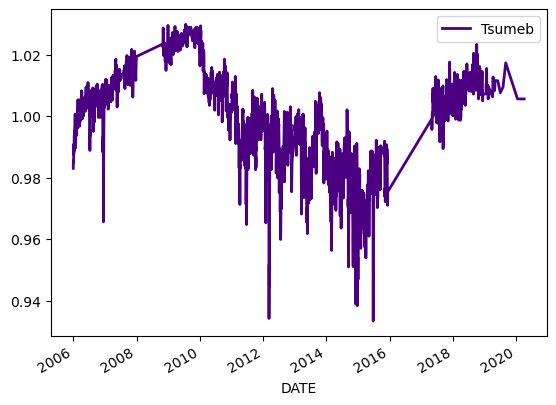

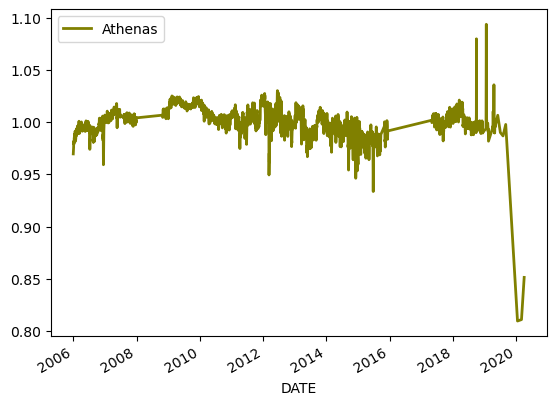

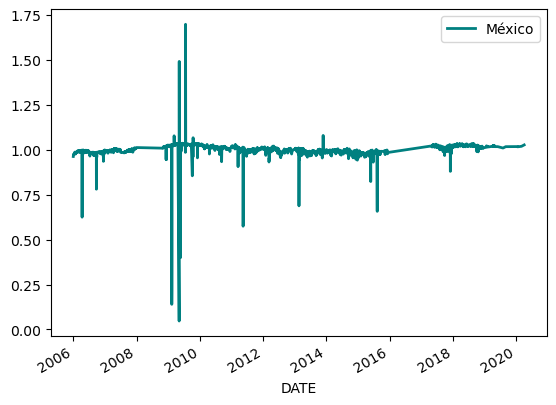

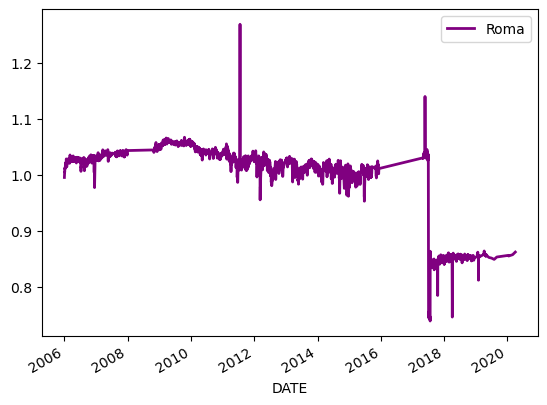

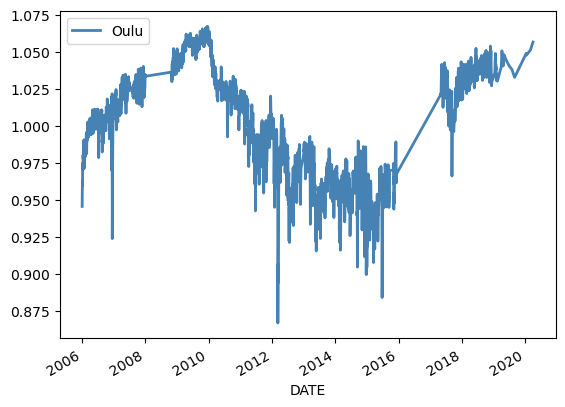

In [113]:
## La mayoría de estaciones son una porquería... esa e sla razón por la que todo el mundo usa Oulu
NZV.plot(x='DATE',y='TSMB',color='indigo',rot=30,linewidth =2, label ="Tsumeb")
NZV.plot(x='DATE',y='ATHN',color='olive',rot=30,linewidth =2, label ="Athenas")
NZV.plot(x='DATE',y='MXCO',color='teal',rot=30,linewidth =2, label ="México")
NZV.plot(x='DATE',y='ROME',color='purple',rot=30,linewidth =2, label ="Roma")
NZV.plot(x='DATE',y='OULU',color='steelblue',rot=30,linewidth =2, label ="Oulu")

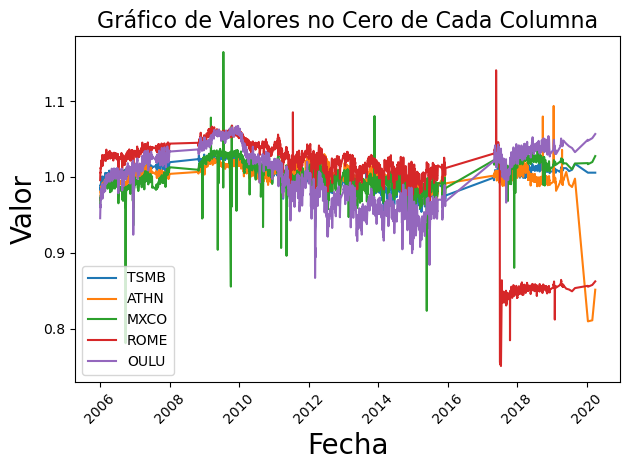

In [115]:
#rgnan.plot(x='DATE',y='TSMB',color='indigo',rot=30,linewidth =2, label ="Tsumeb")
#rgnan.plot(x='DATE',y='ATHN',color='olive',rot=30,linewidth =2, label ="Athenas")
#rgnan.plot(x='DATE',y='MXCO',color='teal',rot=30,linewidth =2, label ="México")
#rgnan.plot(x='DATE',y='ROME',color='purple',rot=30,linewidth =2, label ="Roma")
#rgnan.plot(x='DATE',y='OULU',color='steelblue',rot=30,linewidth =2, label ="Oulu")


# Configura los valores de fecha que deseas mostrar en el eje x
#dates_to_show = ["2011-02-17", "2011-02-19", "2011-02-21"]
# Configura el formato de las etiquetas del eje x
#plt.figsize=(10, 8)

# Convertir las columnas seleccionadas en matrices NumPy
columns_to_plot = NZV.columns[1:]  # Excluye la columna 'DATE'
data_to_plot = NZV[columns_to_plot].to_numpy()

# Obtener las fechas como un arreglo NumPy
fechas = NZV['DATE'].to_numpy()

# Graficar todas las columnas superpuestas
#for i in range(data_to_plot.shape[1]):
#    ax.plot(fechas, data_to_plot[:, i], label=columns_to_plot[i])
for column in NZV.columns[1:]:
    non_zero_values = NZV[(NZV[column] != 0) & (NZV[column] <= 1.25) & (NZV[column] > 0.75)]
    plt.plot(non_zero_values['DATE'].values, non_zero_values[column].values, label=column)

# Configurar etiquetas y leyendas
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('Valor', fontsize=20)
plt.title('Gráfico de Valores no Cero de Cada Columna', fontsize=16)
plt.legend()

# Rotar las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()




#### CONCLUSIÓN TRABAJAREMOS CON OULU

### GRÁFICA DE CADA UNA DE LAS ESTACIONES

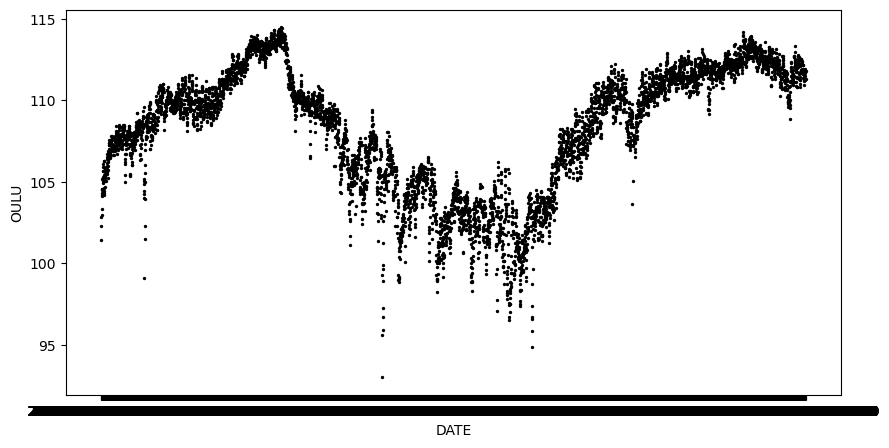

<AxesSubplot:xlabel='DATE'>

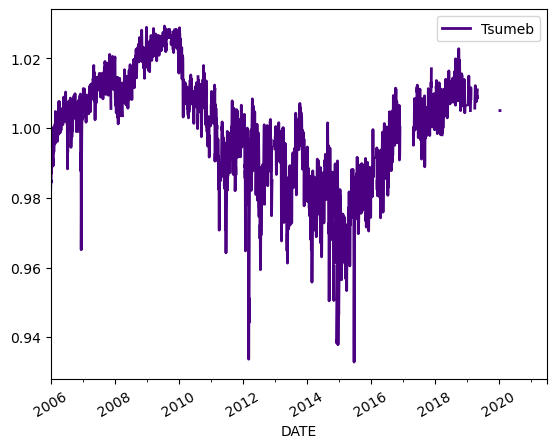

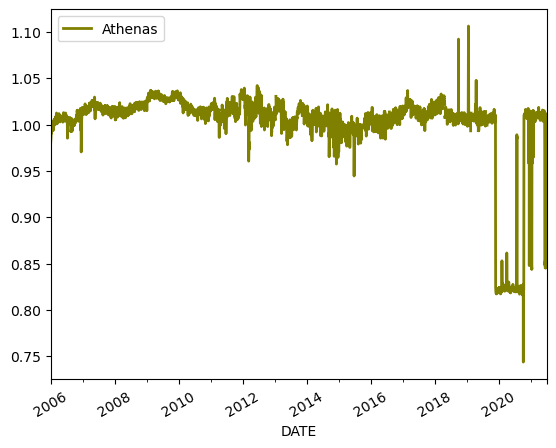

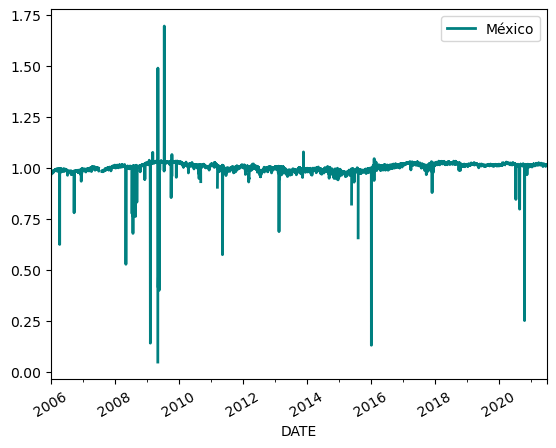

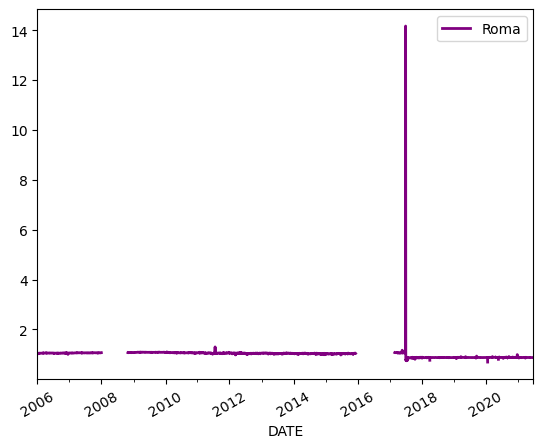

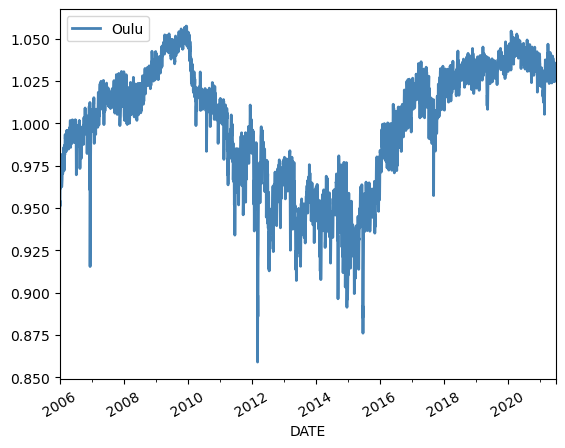

In [5]:
NM = pd.read_csv('NM.csv')
NM

#### ES UN DATO POR DÍA

cutNM = NM[NM['DATE'] >= "2006-01-01"]
cutfNM = cutNM[cutNM['DATE'] <= "2021-12-30" ]
cutfNM.plot(kind='scatter', s= 2, x='DATE',y='OULU', figsize=(10, 5),color='black')
plt.show()
cutfNM.replace('   null', np.nan, inplace=True)

newrg = pd.to_datetime(cutfNM['DATE'])
cutfNM["DATE"] = newrg.values
cutfNM

cutfNM["TSMB"] = cutfNM["TSMB"].astype(float)
cutfNM["ATHN"] = cutfNM["ATHN"].astype(float)
cutfNM["MXCO"] = cutfNM["MXCO"].astype(float)
cutfNM["ROME"] = cutfNM["ROME"].astype(float)
cutfNM["OULU"] = cutfNM["OULU"].astype(float)

# Calcular el promedio de cada columna numérica excepto 'DATE'
columnas_numericas = cutfNM.columns[cutfNM.dtypes == 'float64']
promedios = cutfNM[columnas_numericas].mean()

# Normalizar cada columna dividiendo por su promedio
cutfNM[columnas_numericas] = cutfNM[columnas_numericas] / promedios
cutfNM

## La mayoría de estaciones son una porquería... esa e sla razón por la que todo el mundo usa Oulu
cutfNM.plot(x='DATE',y='TSMB',color='indigo',rot=30,linewidth =2, label ="Tsumeb")
cutfNM.plot(x='DATE',y='ATHN',color='olive',rot=30,linewidth =2, label ="Athenas")
cutfNM.plot(x='DATE',y='MXCO',color='teal',rot=30,linewidth =2, label ="México")
cutfNM.plot(x='DATE',y='ROME',color='purple',rot=30,linewidth =2, label ="Roma")
cutfNM.plot(x='DATE',y='OULU',color='steelblue',rot=30,linewidth =2, label ="Oulu")

# DATOS DE NMDB: the Neutron Monitor Database
## Real-Time Database for high-resolution Neutron Monitor measurements

Trabajo con datos de algunas estaciones directamente.

In [3]:
NM = pd.read_csv('nm_data/NM_izmiran.csv')
NM

,DATE,TSMB,ATHN,MXCO,ROME,OULU
0,2006-01-01 00:00:00,324.971,54.535,217.712,148.928,101.445
1,2006-01-02 00:00:00,325.676,54.639,219.248,149.769,102.270
2,2006-01-03 00:00:00,325.625,54.759,219.858,150.274,102.841
3,2006-01-04 00:00:00,325.846,54.859,219.925,150.447,103.335
4,2006-01-05 00:00:00,325.585,54.897,219.698,150.377,102.962
...,...,...,...,...,...,...
5656,2021-06-27 00:00:00,null,56.098,229.513,127.708,111.792
5657,2021-06-28 00:00:00,null,55.974,228.834,127.550,111.660
5658,2021-06-29 00:00:00,null,56.076,228.892,127.555,111.742
5659,2021-06-30 00:00:00,null,56.167,229.522,128.031,111.810


### DATASETS DE LA NMDB:

In [4]:
skip_rows = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,22,23]

In [5]:
def nmdb_clean(filename):
    skip_rows = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 22, 23]
    df = pd.read_csv(filename, delimiter=';', skiprows=skip_rows, header=None)
    df.columns = ['date', 'counts/s']
    df['date'] = pd.to_datetime(df['date'])
    df['counts/s'] = df['counts/s'].astype('float64')
    print(len(df))
    columnas_numericas = df.columns[df.dtypes == 'float64']
    promedios_df = df[columnas_numericas].mean()

    # Normalizar cada columna dividiendo por su promedio
    df[columnas_numericas] = df[columnas_numericas] / promedios_df

    ################################## ELIMINANDO LOS EXCESOS

    # Supongamos que tienes un DataFrame llamado df y deseas eliminar los excesos en la columna "counts/s"
    # Define la columna objetivo
    column_name = "counts/s"

    # Calcula la media de la columna
    mean = df[column_name].mean()

    # Define un factor para determinar los valores que considerarás excesos
    threshold = 0.1  # 20% por fuera de la media

    # Reemplaza los valores que están por fuera del umbral por el valor medio
    df[column_name] = np.where(abs(df[column_name] - mean) > threshold * mean, mean, df[column_name])

    # Grafica el resultado
    df.plot(kind='scatter', s=2, x='date', y='counts/s', figsize=(10, 5), color='black')
    print(len(df))

    return df


66962
66962


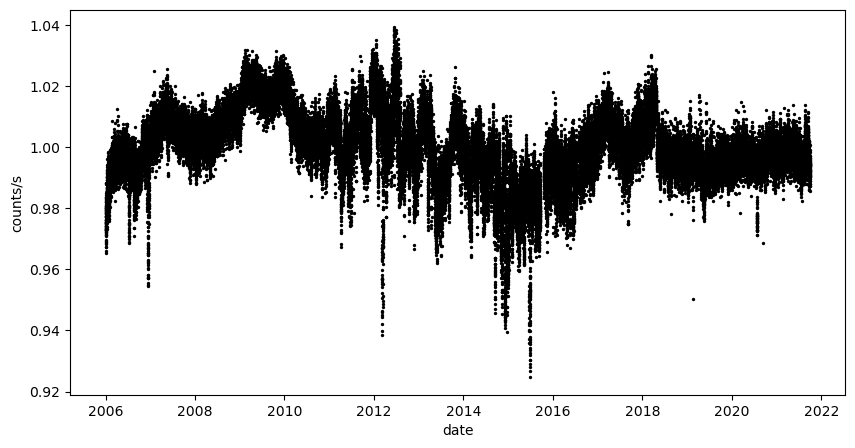

In [6]:
athenas = nmdb_clean('nm_data/athenas_NMDB.txt')

69019
69019


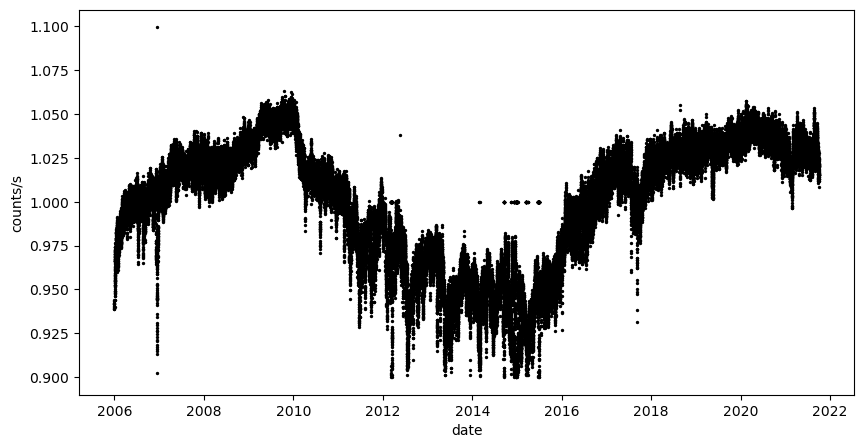

In [7]:
oulu = nmdb_clean('nm_data/Oulu_NMDB.txt')

66853
66853


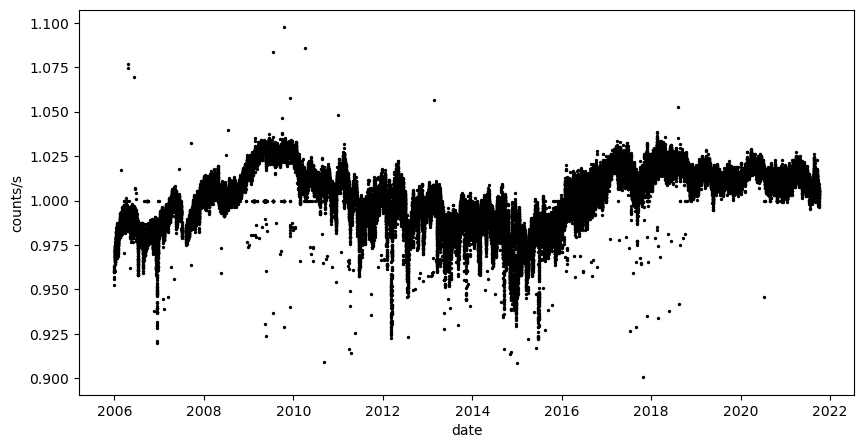

In [8]:
mexico = nmdb_clean('nm_data/mexico_NMDB.txt')

58057
58057


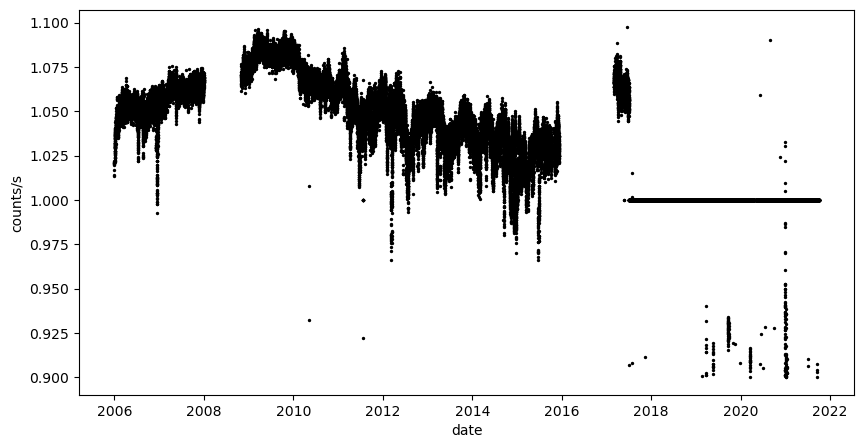

In [9]:
roma = nmdb_clean('nm_data/rome_NMDB.txt')

52340
52340


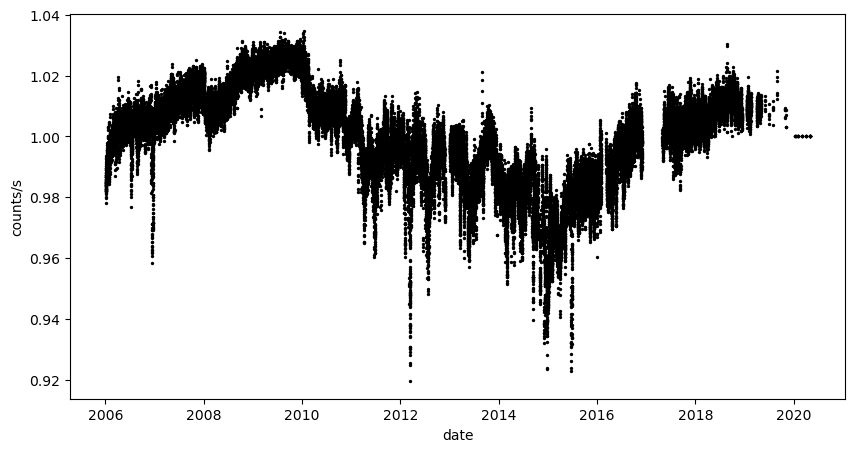

In [10]:
tsumeb = nmdb_clean('nm_data/tsumeb_NMDB.txt')

In [11]:
# Supongamos que tienes 5 DataFrames llamados df1, df2, df3, df4 y df5

# Combinar los DataFrames usando merge
combined_df = athenas.copy()  # Inicializar el DataFrame combinado con df1
#dataframes = [oulu, roma, mexico, tsumeb]
dataframes = [(oulu, "_2"), (roma, "_3"), (mexico, "_4"), (tsumeb, "_5")]

for athenas, suffix in dataframes:
    combined_df = pd.merge_asof(combined_df, athenas, on="date", suffixes=("", suffix))


#for i, athenas in enumerate(dataframes, start=2):
#    combined_df = pd.merge_asof(combined_df, athenas, on="date")

# Ahora combined_df contiene 5 columnas correspondientes a los 5 DataFrames originales
combined_df

,date,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5
0,2006-01-01 00:00:00,0.973060,0.938872,1.020683,0.952384,NaN
1,2006-01-01 02:00:00,0.976032,0.939544,1.020355,0.955791,0.985093
2,2006-01-01 04:00:00,0.972829,0.944137,1.022032,0.956813,0.983959
3,2006-01-01 06:00:00,0.972811,0.941569,1.021306,0.961285,0.982151
4,2006-01-01 08:00:00,0.967348,0.942499,1.020642,0.962325,0.982699
...,...,...,...,...,...,...
66957,2021-09-30 14:00:00,0.991140,1.020587,1.000000,1.005416,1.000000
66958,2021-09-30 16:00:00,0.994058,1.024701,1.000000,1.003530,1.000000
66959,2021-09-30 18:00:00,1.000660,1.022152,1.000000,1.001767,1.000000
66960,2021-09-30 20:00:00,0.999254,1.024314,1.000000,1.003600,1.000000


In [12]:
combined_df = combined_df.fillna(combined_df.mean())
combined_df

,date,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5
0,2006-01-01 00:00:00,0.973060,0.938872,1.020683,0.952384,1.000508
1,2006-01-01 02:00:00,0.976032,0.939544,1.020355,0.955791,0.985093
2,2006-01-01 04:00:00,0.972829,0.944137,1.022032,0.956813,0.983959
3,2006-01-01 06:00:00,0.972811,0.941569,1.021306,0.961285,0.982151
4,2006-01-01 08:00:00,0.967348,0.942499,1.020642,0.962325,0.982699
...,...,...,...,...,...,...
66957,2021-09-30 14:00:00,0.991140,1.020587,1.000000,1.005416,1.000000
66958,2021-09-30 16:00:00,0.994058,1.024701,1.000000,1.003530,1.000000
66959,2021-09-30 18:00:00,1.000660,1.022152,1.000000,1.001767,1.000000
66960,2021-09-30 20:00:00,0.999254,1.024314,1.000000,1.003600,1.000000


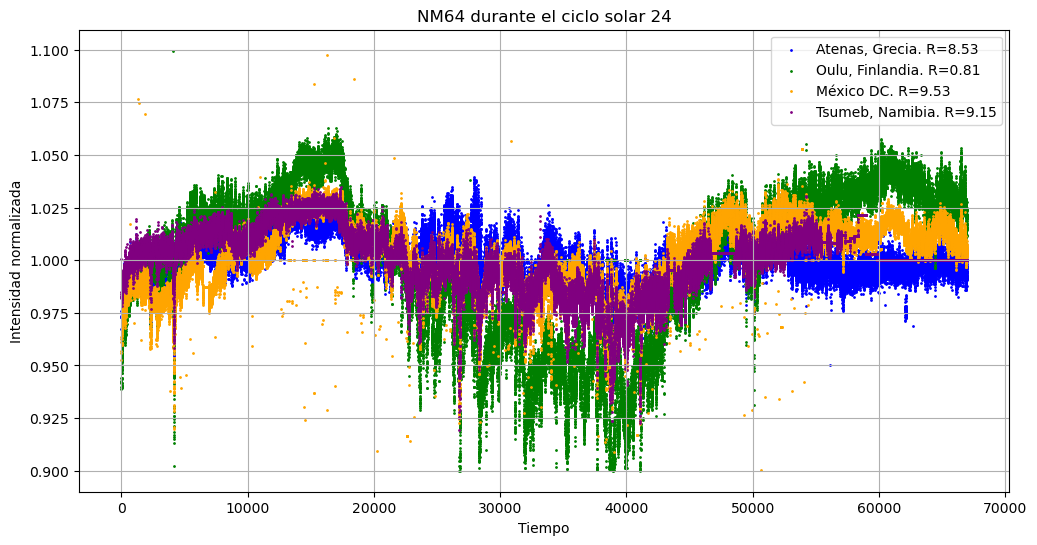

In [13]:
import matplotlib.pyplot as plt

# Suponiendo que combined_df es el DataFrame que contiene las 5 columnas
athenas = combined_df['counts/s'].to_numpy()
oulu = combined_df['counts/s_2'].to_numpy()
#roma = combined_df['counts/s_3'].to_numpy()
mexico = combined_df['counts/s_4'].to_numpy()
tsumeb = combined_df['counts/s_5'].to_numpy()

plt.figure(figsize=(12, 6))
plt.scatter(range(len(athenas)), athenas, color='blue', label='Atenas, Grecia. R=8.53',s=1)
plt.scatter(range(len(oulu)), oulu, color='green', label='Oulu, Finlandia. R=0.81',s=1)
#plt.scatter(range(len(roma)), roma, color='red', label='roma')
plt.scatter(range(len(mexico)), mexico, color='orange', label='México DC. R=9.53',s=1)
plt.scatter(range(len(tsumeb)), tsumeb, color='purple', label='Tsumeb, Namibia. R=9.15',s=1)

plt.xlabel('Tiempo')
plt.ylabel('Intensidad normalizada')
plt.title('NM64 durante el ciclo solar 24')
plt.legend()
plt.grid()
plt.show()


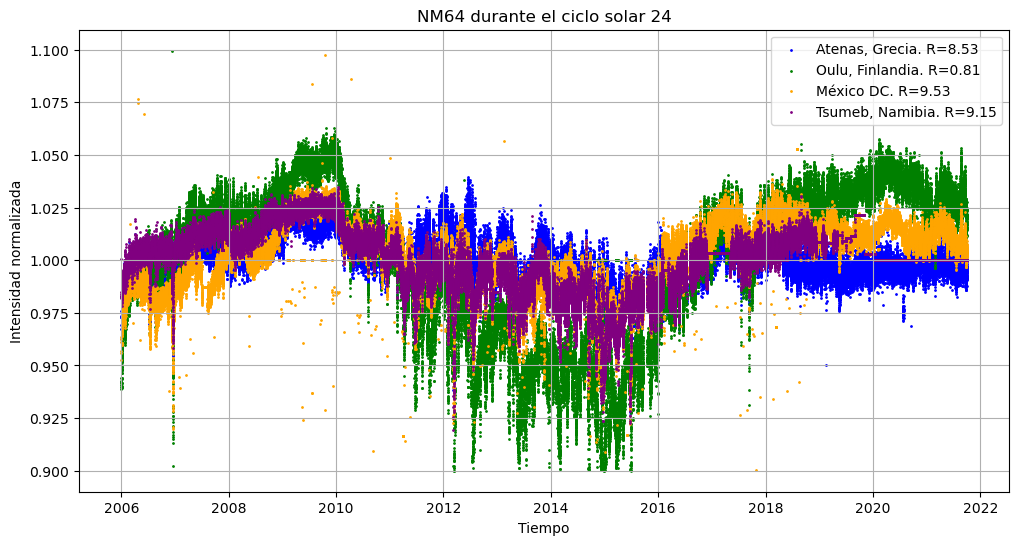

In [14]:
import matplotlib.pyplot as plt

# Suponiendo que combined_df es el DataFrame que contiene las 5 columnas
combined_df.set_index('date', inplace=True)  # Establecer la columna 'date' como el índice

athenas = combined_df['counts/s']
oulu = combined_df['counts/s_2']
#roma = combined_df['counts/s_3']
mexico = combined_df['counts/s_4']
tsumeb = combined_df['counts/s_5']

plt.figure(figsize=(12, 6))
plt.scatter(athenas.index, athenas, color='blue', label='Atenas, Grecia. R=8.53', s=1)
plt.scatter(oulu.index, oulu, color='green', label='Oulu, Finlandia. R=0.81', s=1)
#plt.scatter(roma.index, roma, color='red', label='roma')
plt.scatter(mexico.index, mexico, color='orange', label='México DC. R=9.53', s=1)
plt.scatter(tsumeb.index, tsumeb, color='purple', label='Tsumeb, Namibia. R=9.15', s=1)

plt.xlabel('Tiempo')
plt.ylabel('Intensidad normalizada')
plt.title('NM64 durante el ciclo solar 24')
plt.legend()
plt.grid()
plt.show()



#### Incluimos los datos de Auger

In [15]:
scaler300s = scaler_clean('scaler_datasets/scaler_300s_FINAL.csv','scaler_300s')
scaler300s

Hay  (13663, 6) líneas vacías


/home/jennifer/Documentos/msc_tesis/scaler_for_solar_analysis/augerscalerpy/scaler_cleaning.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SDOK["Date"] = datetime.values


,Date,ScalerCorr,errmean,arrvar,activeSD,pressure
4086,2005-12-31 23:59:46,1604.31,0.226024,2793.15,584,857.586
4088,2006-01-01 00:09:46,1604.69,0.221103,2873.29,548,857.790
4089,2006-01-01 00:14:46,1604.73,0.220782,2696.32,545,857.893
4090,2006-01-01 00:19:46,1602.57,0.210147,2580.66,551,857.995
4091,2006-01-01 00:24:46,1602.63,0.231709,2737.53,538,858.097
...,...,...,...,...,...,...
1527671,2021-09-30 18:34:46,1665.46,0.166624,3694.81,544,856.860
1527672,2021-09-30 18:39:46,1665.10,0.179557,3716.26,549,856.860
1527673,2021-09-30 18:44:46,1666.21,0.215630,3639.40,542,856.815
1527674,2021-09-30 18:49:46,1661.49,0.378396,2635.45,287,856.770


##### Resampling for 2H interval

In [21]:
# Asegúrate de que 'Date' sea el índice del DataFrame
#scaler300s.set_index('Date', inplace=True)

# Resampleando y promediando los datos cada 2 horas
new_df = scaler300s.resample('2H').mean()

# Reiniciando el índice para que 'Date' sea una columna nuevamente
new_df.reset_index(inplace=True)

# Imprimiendo el nuevo DataFrame
print(new_df)

                     Date   ScalerCorr   errmean       arrvar    activeSD  \
0     2005-12-31 22:00:00  1604.310000  0.226024  2793.150000  584.000000   
1     2006-01-01 00:00:00  1603.749565  0.207641  2689.324783  546.956522   
2     2006-01-01 02:00:00  1606.659167  0.200056  2469.276667  561.750000   
3     2006-01-01 04:00:00  1612.899167  0.196147  2486.235000  565.916667   
4     2006-01-01 06:00:00  1619.928333  0.199383  2688.050417  571.166667   
...                   ...          ...       ...          ...         ...   
69018 2021-09-30 10:00:00  1666.532917  0.174400  3292.735417  626.333333   
69019 2021-09-30 12:00:00  1672.022917  0.181023  3464.774583  601.791667   
69020 2021-09-30 14:00:00  1668.891250  0.186957  3481.860000  588.458333   
69021 2021-09-30 16:00:00  1665.408333  0.179832  3658.545417  575.208333   
69022 2021-09-30 18:00:00  1664.736364  0.283859  3611.068182  486.818182   

         pressure  
0      857.586000  
1      858.915609  
2      861.0405

In [33]:
combined_df

,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5
date,,,,,
2006-01-01 00:00:00,0.973060,0.938872,1.020683,0.952384,1.000508
2006-01-01 02:00:00,0.976032,0.939544,1.020355,0.955791,0.985093
2006-01-01 04:00:00,0.972829,0.944137,1.022032,0.956813,0.983959
2006-01-01 06:00:00,0.972811,0.941569,1.021306,0.961285,0.982151
2006-01-01 08:00:00,0.967348,0.942499,1.020642,0.962325,0.982699
...,...,...,...,...,...
2021-09-30 14:00:00,0.991140,1.020587,1.000000,1.005416,1.000000
2021-09-30 16:00:00,0.994058,1.024701,1.000000,1.003530,1.000000
2021-09-30 18:00:00,1.000660,1.022152,1.000000,1.001767,1.000000


In [34]:
combined_df.reset_index(inplace=True)
combined_df

,date,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5
0,2006-01-01 00:00:00,0.973060,0.938872,1.020683,0.952384,1.000508
1,2006-01-01 02:00:00,0.976032,0.939544,1.020355,0.955791,0.985093
2,2006-01-01 04:00:00,0.972829,0.944137,1.022032,0.956813,0.983959
3,2006-01-01 06:00:00,0.972811,0.941569,1.021306,0.961285,0.982151
4,2006-01-01 08:00:00,0.967348,0.942499,1.020642,0.962325,0.982699
...,...,...,...,...,...,...
66957,2021-09-30 14:00:00,0.991140,1.020587,1.000000,1.005416,1.000000
66958,2021-09-30 16:00:00,0.994058,1.024701,1.000000,1.003530,1.000000
66959,2021-09-30 18:00:00,1.000660,1.022152,1.000000,1.001767,1.000000
66960,2021-09-30 20:00:00,0.999254,1.024314,1.000000,1.003600,1.000000


In [35]:
import pandas as pd

# Supongamos que tienes los DataFrames "combined_df" y "new_df"
# Establece la columna "Date" como índice en ambos DataFrames
combined_df.set_index("date", inplace=True)
new_df.set_index("Date", inplace=True)

# Realiza la fusión en función del índice (que ahora es la columna "Date")
result_df = pd.merge_asof(combined_df, new_df, left_index=True, right_index=True, suffixes=("", "_new"))

# Restablece el índice si lo deseas
result_df.reset_index(inplace=True)

# "result_df" contiene las 6 columnas originales y "ScalerCorr_new" del DataFrame "new_df"
result_df

,date,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5,ScalerCorr,errmean,arrvar,activeSD,pressure
0,2006-01-01 00:00:00,0.973060,0.938872,1.020683,0.952384,1.000508,1603.749565,0.207641,2689.324783,546.956522,858.915609
1,2006-01-01 02:00:00,0.976032,0.939544,1.020355,0.955791,0.985093,1606.659167,0.200056,2469.276667,561.750000,861.040500
2,2006-01-01 04:00:00,0.972829,0.944137,1.022032,0.956813,0.983959,1612.899167,0.196147,2486.235000,565.916667,861.633750
3,2006-01-01 06:00:00,0.972811,0.941569,1.021306,0.961285,0.982151,1619.928333,0.199383,2688.050417,571.166667,861.174167
4,2006-01-01 08:00:00,0.967348,0.942499,1.020642,0.962325,0.982699,1620.802083,0.197175,2678.818333,570.666667,860.681667
...,...,...,...,...,...,...,...,...,...,...,...
66957,2021-09-30 14:00:00,0.991140,1.020587,1.000000,1.005416,1.000000,1668.891250,0.186957,3481.860000,588.458333,858.081875
66958,2021-09-30 16:00:00,0.994058,1.024701,1.000000,1.003530,1.000000,1665.408333,0.179832,3658.545417,575.208333,857.493167
66959,2021-09-30 18:00:00,1.000660,1.022152,1.000000,1.001767,1.000000,1664.736364,0.283859,3611.068182,486.818182,856.868636
66960,2021-09-30 20:00:00,0.999254,1.024314,1.000000,1.003600,1.000000,1664.736364,0.283859,3611.068182,486.818182,856.868636


In [37]:
# Reemplazar NaN en "ScalerCorr" por el promedio de la columna
mean_scaler_corr = result_df["ScalerCorr"].mean()
result_df["ScalerCorr"].fillna(mean_scaler_corr, inplace=True)

# Reemplazar NaN en "errmean" por cero
result_df["errmean"].fillna(0, inplace=True)
result_df

,date,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5,ScalerCorr,errmean,arrvar,activeSD,pressure
0,2006-01-01 00:00:00,0.973060,0.938872,1.020683,0.952384,1.000508,1603.749565,0.207641,2689.324783,546.956522,858.915609
1,2006-01-01 02:00:00,0.976032,0.939544,1.020355,0.955791,0.985093,1606.659167,0.200056,2469.276667,561.750000,861.040500
2,2006-01-01 04:00:00,0.972829,0.944137,1.022032,0.956813,0.983959,1612.899167,0.196147,2486.235000,565.916667,861.633750
3,2006-01-01 06:00:00,0.972811,0.941569,1.021306,0.961285,0.982151,1619.928333,0.199383,2688.050417,571.166667,861.174167
4,2006-01-01 08:00:00,0.967348,0.942499,1.020642,0.962325,0.982699,1620.802083,0.197175,2678.818333,570.666667,860.681667
...,...,...,...,...,...,...,...,...,...,...,...
66957,2021-09-30 14:00:00,0.991140,1.020587,1.000000,1.005416,1.000000,1668.891250,0.186957,3481.860000,588.458333,858.081875
66958,2021-09-30 16:00:00,0.994058,1.024701,1.000000,1.003530,1.000000,1665.408333,0.179832,3658.545417,575.208333,857.493167
66959,2021-09-30 18:00:00,1.000660,1.022152,1.000000,1.001767,1.000000,1664.736364,0.283859,3611.068182,486.818182,856.868636
66960,2021-09-30 20:00:00,0.999254,1.024314,1.000000,1.003600,1.000000,1664.736364,0.283859,3611.068182,486.818182,856.868636


##### Toca normalizar ScalerCorr para que se pueda comparar...

In [38]:
promedios_df = result_df['ScalerCorr'].mean()

    # Normalizar cada columna dividiendo por su promedio
result_df['ScalerCorr'] = result_df['ScalerCorr'] / promedios_df
result_df

,date,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5,ScalerCorr,errmean,arrvar,activeSD,pressure
0,2006-01-01 00:00:00,0.973060,0.938872,1.020683,0.952384,1.000508,0.966655,0.207641,2689.324783,546.956522,858.915609
1,2006-01-01 02:00:00,0.976032,0.939544,1.020355,0.955791,0.985093,0.968409,0.200056,2469.276667,561.750000,861.040500
2,2006-01-01 04:00:00,0.972829,0.944137,1.022032,0.956813,0.983959,0.972170,0.196147,2486.235000,565.916667,861.633750
3,2006-01-01 06:00:00,0.972811,0.941569,1.021306,0.961285,0.982151,0.976407,0.199383,2688.050417,571.166667,861.174167
4,2006-01-01 08:00:00,0.967348,0.942499,1.020642,0.962325,0.982699,0.976933,0.197175,2678.818333,570.666667,860.681667
...,...,...,...,...,...,...,...,...,...,...,...
66957,2021-09-30 14:00:00,0.991140,1.020587,1.000000,1.005416,1.000000,1.005919,0.186957,3481.860000,588.458333,858.081875
66958,2021-09-30 16:00:00,0.994058,1.024701,1.000000,1.003530,1.000000,1.003820,0.179832,3658.545417,575.208333,857.493167
66959,2021-09-30 18:00:00,1.000660,1.022152,1.000000,1.001767,1.000000,1.003415,0.283859,3611.068182,486.818182,856.868636
66960,2021-09-30 20:00:00,0.999254,1.024314,1.000000,1.003600,1.000000,1.003415,0.283859,3611.068182,486.818182,856.868636


/tmp/ipykernel_64471/2470155994.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('NM_Auger_comparison.pdf', dpi=300)
/tmp/ipykernel_64471/2470155994.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('NM_Auger_comparison.pdf', dpi=300)
/tmp/ipykernel_64471/2470155994.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('NM_Auger_comparison.png')
/home/jennifer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


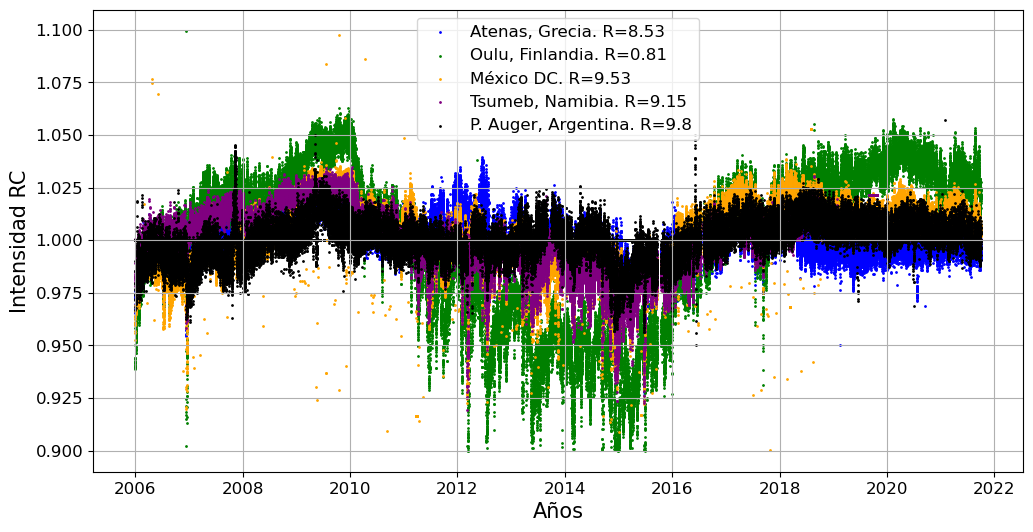

In [56]:
import matplotlib.pyplot as plt

# Suponiendo que combined_df es el DataFrame que contiene las 5 columnas
#result_df.set_index('date', inplace=True)  # Establecer la columna 'date' como el índice

athenas = result_df['counts/s']
oulu = result_df['counts/s_2']
#roma = combined_df['counts/s_3']
mexico = result_df['counts/s_4']
tsumeb = result_df['counts/s_5']
auger = result_df['ScalerCorr']

plt.figure(figsize=(12, 6))
plt.scatter(athenas.index, athenas, color='blue', label='Atenas, Grecia. R=8.53',marker='o', s=1)
plt.scatter(oulu.index, oulu, color='green', label='Oulu, Finlandia. R=0.81',marker='o', s=1)
#plt.scatter(roma.index, roma, color='red', label='roma')
plt.scatter(mexico.index, mexico, color='orange', label='México DC. R=9.53',marker='o', s=1)
plt.scatter(tsumeb.index, tsumeb, color='purple', label='Tsumeb, Namibia. R=9.15',marker='o', s=1)
plt.scatter(auger.index, auger, color='black', label='P. Auger, Argentina. R=9.8',marker='o', s=1)


plt.xlabel('Años', fontsize=15)
plt.ylabel('Intensidad RC', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('')
plt.legend(fontsize=12)
#legend = plt.legend(fontsize=12)
#for line in legend.get_lines():
#    line.set_markersize(20)  # Aumenta el tamaño de los marcadores
plt.grid()
plt.savefig('NM_Auger_comparison.pdf', dpi=300)
plt.savefig('NM_Auger_comparison.png')
plt.show()

/tmp/ipykernel_64471/4291039019.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('NM_Auger_comparison.pdf', dpi=300)
/tmp/ipykernel_64471/4291039019.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('NM_Auger_comparison.pdf', dpi=300)
/tmp/ipykernel_64471/4291039019.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('NM_Auger_comparison.png')
/home/jennifer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


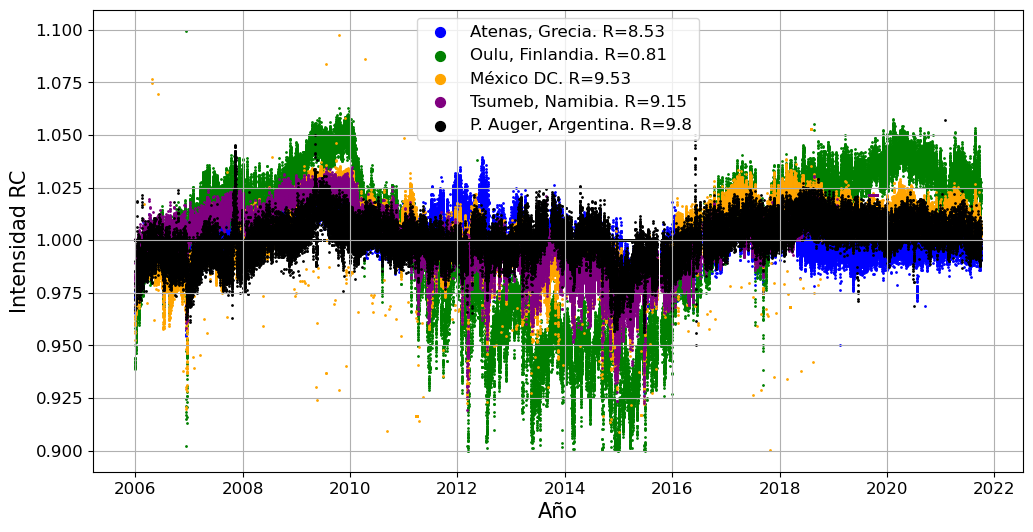

In [58]:
import matplotlib.pyplot as plt

athenas = result_df['counts/s']
oulu = result_df['counts/s_2']
# roma = combined_df['counts/s_3']
mexico = result_df['counts/s_4']
tsumeb = result_df['counts/s_5']
auger = result_df['ScalerCorr']

plt.figure(figsize=(12, 6))
plt.scatter(athenas.index, athenas, color='blue', label='Atenas, Grecia. R=8.53', marker='o', s=1)
plt.scatter(oulu.index, oulu, color='green', label='Oulu, Finlandia. R=0.81', marker='o', s=1)
# plt.scatter(roma.index, roma, color='red', label='roma')
plt.scatter(mexico.index, mexico, color='orange', label='México DC. R=9.53', marker='o', s=1)
plt.scatter(tsumeb.index, tsumeb, color='purple', label='Tsumeb, Namibia. R=9.15', marker='o', s=1)
plt.scatter(auger.index, auger, color='black', label='P. Auger, Argentina. R=9.8', marker='o', s=1)

plt.xlabel('Año', fontsize=15)
plt.ylabel('Intensidad RC', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('')

# Crear una leyenda personalizada con marcadores más grandes
legend = plt.legend(fontsize=12)
for handle in legend.legendHandles:
    handle.set_sizes([50])  # Ajustar el tamaño de los marcadores en la leyenda

plt.grid()
plt.savefig('NM_Auger_comparison.pdf', dpi=300)
plt.savefig('NM_Auger_comparison.png')
plt.show()
